# Notebook Contents


In [2]:
from IPython.core.display import HTML

In [3]:
import os
import pyodbc 
import pandas             as pd
import numpy              as np
import seaborn            as sns
import matplotlib.pyplot  as plt

# Comment this if the data visualisations doesn't work
%matplotlib inline
plt.style.use('bmh')

In [4]:
# required pyodbc

conn_str = (
    r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
    r'DBQ=Z:\Swedwood KR\Department Production\Technologist\BOM\DB\Inventories_v3_be.accdb;'
    r'UID=user;'
    r'PWD=;'
    )
cnxn = pyodbc.connect(conn_str)

In [5]:
sql = """   
    SELECT 
        ITEMCHAR.WC as WorckCenter,
        ITEMCHAR.ITEM_ID as ProductAGR,
        ITEMCHAR.ITEM_NAME as ProductName,
        ITEMCHAR.NPC_MAX as NPC, 
        ITEMCHAR.QTY_BLANK_1 as Parts,
        ITEMCHAR.MARSRUTAS as Path,
        ITEMCHAR.WIDTH_1 as Width,
        ITEMCHAR.LENGHT_1 as Lenght,      
        ITEMCHAR.Liftas_Past as LiftPushSpeed,
        ITEMCHAR.Liftas_nuos_veikimas as LiftRegularSpeed,
        ITEMCHAR.pas_stal_iejimas as RT1EntranceSpeed,
        ITEMCHAR.pas_stal_isejimas as RT1ExitSpeed,     
        ITEMCHAR.[2_pas_stal_iejimas] as RT2EntranceSpeed,
        ITEMCHAR.[2_pas_stal_isejimas] as RT2ExitSpeed,
        ITEMCHAR.[1_krast_stak_pastuma] as EM1PushSpeed,
        ITEMCHAR.[1_krast_stak_Ciklas] as EM1PushCycle,
        ITEMCHAR.[2_krast_stak_pastuma] as EM2PushSpeed, 
        ITEMCHAR.[2_krast_stak_Ciklas] as EM2PushCycle,  
        ITEMCHAR.[1_krast_stak_Kumstelio_sk] as Position,        
        
        LEFT(ITEM_ID, inStr(ITEM_ID, '-')+2) +
            COLLORS.COLINX +
            RIGHT(ITEM_ID, LEN(ITEM_ID)-(inStr(ITEM_ID, '-')+3)) as Product,
            
        LEFT(ITEM_ID, inStr(ITEM_ID, '-')-1) as BR 
        
    FROM ITEMCHAR, COLLORS
    WHERE 
        ITEMCHAR.COLOR_INDEX = COLLORS.UNKNOWN AND 
        WC in (12020, 12010) AND
        ITEMCHAR.archivuotas = False
        
    """
data = pd.read_sql(sql,cnxn);

# Data description:

* **WorckCenter** - Worck center (Mashine) ID number in ouer system;
* **ProductAGR** - Product ID with eliminated color parameter where suposte be color here 'X' *example: BR3-ITX104 color can be W (White), B (Black), O (Oack) or any else*;
* **Product**
* **BR** - Basic group of operation level;
* **ProductName**
* **NPC** - Name Plate Capacity;
* **Parts** - Some raw product whe need cut this indicator shows how many items we have in this raw product;
* **Path**
* **Width**
* **Lenght**      
* **LiftPushSpeed**
* **LiftRegularSpeed**
* **RT1EntranceSpeed**
* **RT1ExitSpeed**  
* **RT2EntranceSpeed**
* **RT2ExitSpeed**
* **EM1PushSpeed**
* **EM1PushCycle**
* **EM2PushSpeed**
* **EM2PushCycle**  
* **Position**

# Data Mungy

Check data sets for missing values

In [6]:
print('Bad rows (with missing values) caunt: ', data.shape[0]-data.dropna().shape[0],
     '\nRaw data shape: ', data.shape,
     '\nClean data shape: ', data.dropna().shape,);

Bad rows (with missing values) caunt:  215 
Raw data shape:  (1320, 21) 
Clean data shape:  (1105, 21)


In [7]:
data = data.fillna(value = 0)

Seperate data to differents categorys by type

In [8]:
continuous = ['NPC', 'Width', 'Lenght', 'LiftPushSpeed', 'LiftRegularSpeed', 
              'RT1EntranceSpeed', 'RT1ExitSpeed', 'RT2EntranceSpeed', 'RT2ExitSpeed',
              'EM1PushSpeed', 'EM1PushCycle', 'EM2PushSpeed', 'EM2PushCycle', 'Parts']

categorical = ['ProductAGR', 'ProductName', 'Product', 'WorckCenter', 'Position', 'BR']

binary = ['Path']

In [9]:
data[continuous] = data[continuous].astype(np.float64)
data[categorical] = data[categorical].astype(np.object)
data[binary] = data[binary].astype(np.object)

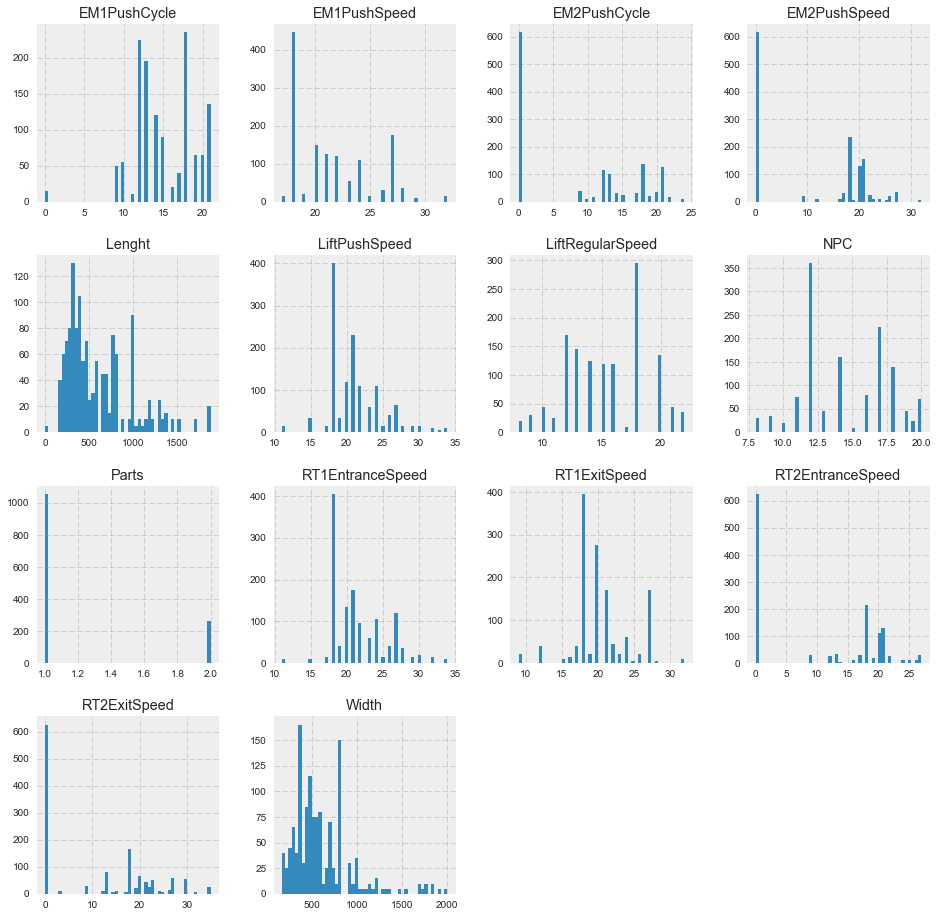

In [10]:
data[continuous + categorical].hist(figsize=(16, 16), bins=50, xlabelsize=10, ylabelsize=10);

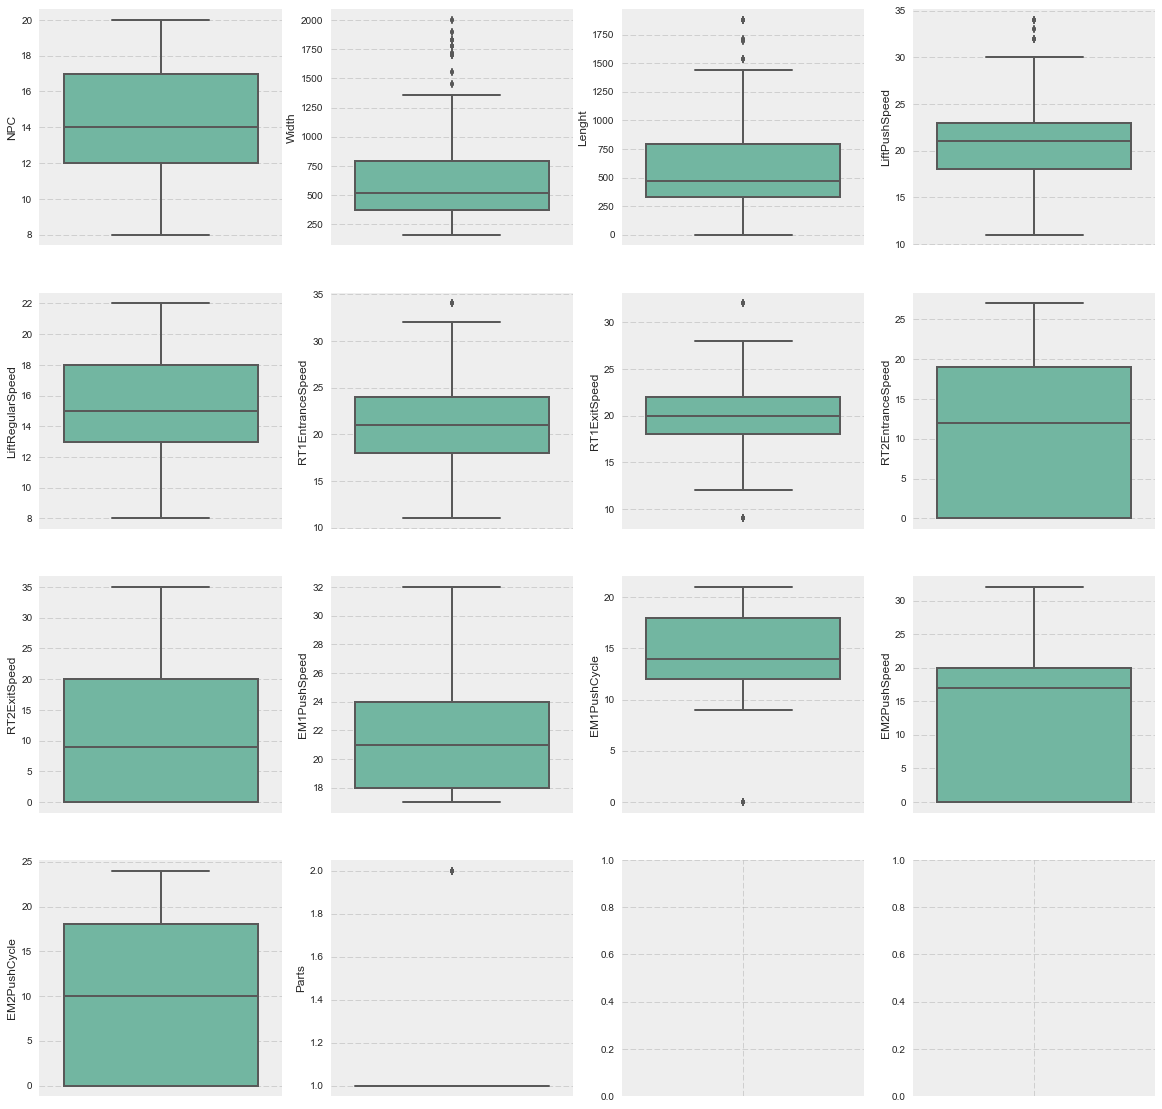

In [11]:
fig, axes = plt.subplots(4,4, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, row in zip(axes, continuous):
    
    sns.boxplot(
                data=data,
                y=row,
                ax = ax,
                palette="Set2")

### Correlation

In [12]:
data.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [13]:
dataCorr = data.corr(method='pearson')
# viariant when matrix is diogonal
dataCorr = dataCorr.mask(np.tril(np.ones(dataCorr.shape)).astype(np.bool))

# when need all correlation items
dataCorr = dataCorr[abs(dataCorr) >= 0.7].stack().reset_index()

# when need just NPC correlation
# dataCorr = dataCorr.stack().reset_index()
# dataCorr = dataCorr[dataCorr.level_0 == 'NPC']
dataCorr

,level_0,level_1,0
0,LiftPushSpeed,RT1EntranceSpeed,0.879219
1,RT1EntranceSpeed,EM1PushSpeed,0.798773
2,RT2EntranceSpeed,RT2ExitSpeed,0.933675
3,RT2EntranceSpeed,EM2PushSpeed,0.967795
4,RT2EntranceSpeed,EM2PushCycle,0.949881
5,RT2ExitSpeed,EM2PushSpeed,0.907981
6,RT2ExitSpeed,EM2PushCycle,0.914859
7,EM2PushSpeed,EM2PushCycle,0.947893


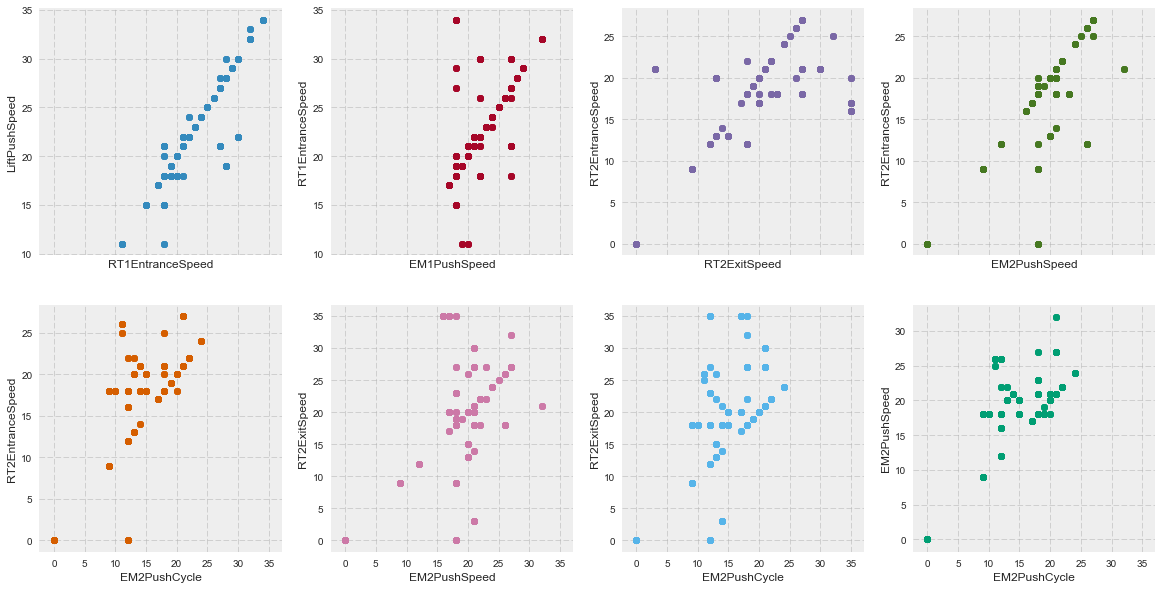

In [14]:
fig, axes = plt.subplots(2,4, figsize=(20,10), sharex=True)
axes = axes.flatten()

for ax, row in zip(axes, dataCorr.itertuples(index=True, name= 'Pandas')):
    
    sns.regplot(data=data,
                x=getattr(row, 'level_1'),
                y=getattr(row, 'level_0'),
                ax = ax,
                fit_reg=False)

**Įžvalgos:** duomenų porų pasiskirtymę visose porose įžvelgiamas tiesinis ryšys. *(Augant įėjimo greičiui auga ir išėjimo greitis kas riamentis ekspertine nuomuone yra pilnai suprantama)* Tiesinė priklausomybė įžvelgiama visose porose, skirtingi tik priklausomybės stiprumai tarp porų. 

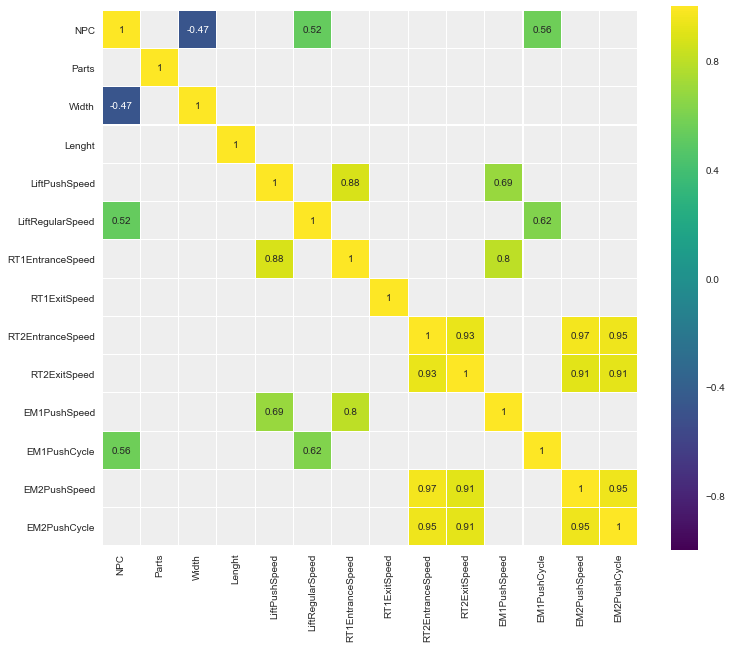

In [15]:
corr = data.corr(method='pearson') # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

p = sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 10}, square=True);


Peržvelgus duomenis įžvelgiamos teigiamos korelecijos pilnai suprantamos remiantis tuo, kad charakterizuojami duomenys yra didžioji dalis apdirbimo linijos įvairių segmentų pastųmos greičiai *(Tarpusavio sasaja tiesinis ryšys)*. Įdomesnė neigiama korelecija tarp NPC *(detalių skaičius per minutę)* ir Width *(detalių pločio)*. Detalės plotis veikia neigiamai NPC t.y. kuo didesnis detalės plotis tuo mažesnis NPC

### Data Boxplots and etc.

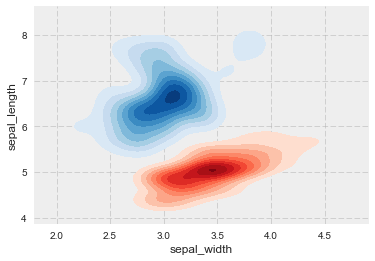

In [16]:
iris = sns.load_dataset("iris")
setosa = iris.loc[iris.species == "setosa"]
virginica = iris.loc[iris.species == "virginica"]


ax = sns.kdeplot(setosa.sepal_width, setosa.sepal_length,
                  cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(virginica.sepal_width, virginica.sepal_length,
                  cmap="Blues", shade=True, shade_lowest=False)